In [ ]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import mne
mne.__version__

In [ ]:
import sys
path_utils = 'decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

In [ ]:
subjs_list = ['s01', 's02', 's03','s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' ]
path = 'Cond_CJ_EEG'

In [ ]:
epochs = []
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
    epochs.append(epoch.average());
    # print(isubj)

In [ ]:
gvaverage = mne.grand_average(epochs[:])

In [ ]:
# Scorer: non parametric R²
from sklearn.metrics import roc_auc_score

def prob_scorer(y_true, y_pred):
    """Score probabilistic outputs for a single class as the other class is the numerical complement."""
    return roc_auc_score(y_true, y_pred)

In [ ]:
all_epochs = []
all_rawdata = [None] * np.size(subjs_list)
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
    subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
    all_rawdata[isubj] =  subj_data
    all_epochs.append(epoch);
    epoch.metadata

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

In [70]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np

# from decoding_toolbox_py.Helper_funcs import DecToolbox as dt
# from decoding_toolbox_py.Helper_funcs.base_stats import corr_linear_circular
# from decoding_toolbox_py.Helper_funcs.classifier_funcs import scorer_angle, AngularRegression

import DecToolbox as dt
from base_stats import corr_linear_circular
from classifier_funcs import scorer_angle, AngularClassifier



# import DecToolbox as dt # pip install dectool 

from mne import read_epochs
from mne.decoding import SlidingEstimator,GeneralizingEstimator

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVR, SVC
# from base_stats import corr_linear_circular
from sklearn import preprocessing
# from classifier_funcs import AngularRegression, scorer_angle
import time as tm
from sklearn.model_selection import KFold

from catboost import CatBoostClassifier

time = gvaverage.times
n_time = len(time)
n_time = 1
#%%capture --no-display
clf = SVC(kernel='linear')
clf = SVC(kernel='linear', probability=True)
clf = CatBoostClassifier()
a = tm.time() 
nfold = 5 # folds for crossvalidations

nSubj = np.size(subjs_list)
scorer_deci_subjs = np.zeros((nSubj,n_time))
scorer_deci_fold_subjs = np.zeros((nfold,n_time))
lab = preprocessing.LabelEncoder()

for ival, isubj in enumerate(subjs_list):
    print(ival, isubj)
    Y = all_rawdata[ival]['epoch_dat'] 
    all_rawdata[ival]['metadata']['condv'] = 'C'
    all_rawdata[ival]['metadata'].loc[all_rawdata[ival]['metadata']['cond']== 1, 'condv'] =  'D'
    dv  = np.array(all_rawdata[ival]['metadata'].condv)
    dv = lab.fit_transform(dv)
    
    #dv = lab.fit_transform(dv)
   # binned_dv = np.digitize(dv, bins = np.array([ -0.3,0,0.3 ]) ) # bins collapsing degrees by similarity

    FoldsIdx = dt.CreateFolds(dv, Y, nfold)
    
    print(np.shape(dv), np.shape(Y))

    for ifold, fold in enumerate(FoldsIdx):
        train_ix = fold['train_index']
        test_ix = fold['test_index']
        # print(n_time)
        for it in range(n_time):
        # for it in range(10):
            Ytime = Y[:,:,it]
            scaler = StandardScaler().fit(Ytime)
            Ytime = scaler.transform(Ytime)
            print(Ytime[train_ix,:].shape , dv[train_ix].shape)
            clf.fit( Ytime[train_ix,:], dv[train_ix])
            preds = clf.predict(X = Ytime[test_ix])
            scorer_deci_fold_subjs[ifold, it] = prob_scorer(dv[test_ix],preds)
            # draw_roc_curve(dv[test_ix], preds)
            
    scorer_deci_subjs[ival, : ] = np.mean(scorer_deci_fold_subjs, axis = 0)
b = tm.time()

0 s01
(250,) (250, 32, 2876)
(200, 32) (200,)
Learning rate set to 0.005182
0:	learn: 0.6922887	total: 71ms	remaining: 1m 10s
1:	learn: 0.6915410	total: 79.1ms	remaining: 39.5s
2:	learn: 0.6905744	total: 84.9ms	remaining: 28.2s
3:	learn: 0.6899175	total: 89.8ms	remaining: 22.4s
4:	learn: 0.6889527	total: 94.3ms	remaining: 18.8s
5:	learn: 0.6878209	total: 104ms	remaining: 17.2s
6:	learn: 0.6869240	total: 108ms	remaining: 15.3s
7:	learn: 0.6853146	total: 112ms	remaining: 13.9s
8:	learn: 0.6844846	total: 118ms	remaining: 13s
9:	learn: 0.6839133	total: 122ms	remaining: 12.1s
10:	learn: 0.6831660	total: 125ms	remaining: 11.2s
11:	learn: 0.6822159	total: 128ms	remaining: 10.5s
12:	learn: 0.6808640	total: 132ms	remaining: 9.99s
13:	learn: 0.6802925	total: 135ms	remaining: 9.53s
14:	learn: 0.6795682	total: 142ms	remaining: 9.31s
15:	learn: 0.6786231	total: 147ms	remaining: 9.01s
16:	learn: 0.6778854	total: 150ms	remaining: 8.67s
17:	learn: 0.6766435	total: 154ms	remaining: 8.39s
18:	learn: 0.6

TypeError: CatBoostClassifier.predict() got an unexpected keyword argument 'X'

In [ ]:
print(b-a)

In [ ]:
time = gvaverage.times
# n_time = len(time)
n_time = 4
#%%capture --no-display
# clf = SVC(kernel='linear')
clf = SVC(kernel='linear', probability=True)
a = tm.time() 

nfold = 5 # folds for crossvalidations

nSubj = np.size(subjs_list)
scorer_deci_subjs = np.zeros((nSubj,n_time))
scorer_deci_fold_subjs = np.zeros((nfold,n_time))
lab = preprocessing.LabelEncoder()

for ival, isubj in enumerate(subjs_list):
    print(ival, isubj)
    Y = all_rawdata[ival]['epoch_dat'] 
    all_rawdata[ival]['metadata']['condv'] = 'C'
    all_rawdata[ival]['metadata'].loc[all_rawdata[ival]['metadata']['cond']== 1, 'condv'] =  'D'
    dv  = np.array(all_rawdata[ival]['metadata'].condv)
    dv = lab.fit_transform(dv)
    
    #dv = lab.fit_transform(dv)
   # binned_dv = np.digitize(dv, bins = np.array([ -0.3,0,0.3 ]) ) # bins collapsing degrees by similarity

    FoldsIdx = dt.CreateFolds(dv, Y, nfold)
    
    print(np.shape(dv), np.shape(Y))

    for ifold, fold in enumerate(FoldsIdx):
        train_ix = fold['train_index']
        test_ix = fold['test_index']
        # print(n_time)
        for it in range(n_time):
        # for it in range(10):
            Ytime = Y[:,:,it]
            scaler = StandardScaler().fit(Ytime)
            Ytime = scaler.transform(Ytime)
            
            clf.fit( Ytime[train_ix,:], dv[train_ix])
            preds = clf.predict(X = Ytime[test_ix])
            scorer_deci_fold_subjs[ifold, it] = prob_scorer(dv[test_ix],preds)
            # draw_roc_curve(dv[test_ix], preds)
            
    scorer_deci_subjs[ival, : ] = np.mean(scorer_deci_fold_subjs, axis = 0)
b = tm.time()

In [33]:
ival = 1

In [65]:
Y = all_rawdata[ival]['epoch_dat'] 
all_rawdata[ival]['metadata']['condv'] = 'C'
all_rawdata[ival]['metadata'].loc[all_rawdata[ival]['metadata']['cond']== 1, 'condv'] =  'D'
dv  = np.array(all_rawdata[ival]['metadata'].condv)
print(dv)
dv = lab.fit_transform(dv)
print(dv)


['D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D'
 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D'
 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D'
 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D'
 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D'
 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D'
 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'D

(261,)


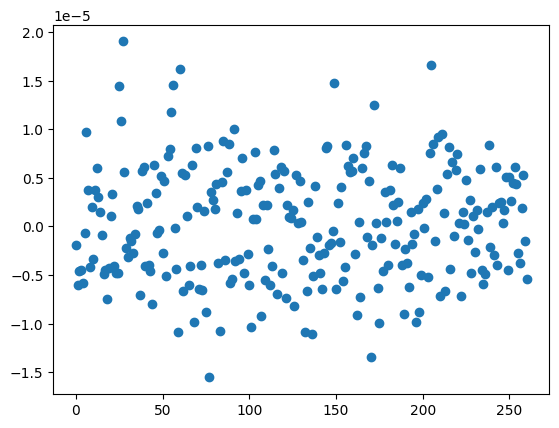

In [63]:
print(Y[:,0,0].shape)
xx = [i for i in range(len(Y))]
plt.scatter(xx, Y[:,0,0])

# mne.viz.plot_raw(Y[:,0,0])

In [66]:
Y.shape

(261, 32, 2876)

In [39]:
#!pip install catboost

In [40]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier



In [75]:
ival = 1

Y = all_rawdata[ival]['epoch_dat'] 
all_rawdata[ival]['metadata']['condv'] = 'C'
all_rawdata[ival]['metadata'].loc[all_rawdata[ival]['metadata']['cond']== 1, 'condv'] =  'D'
dv  = np.array(all_rawdata[ival]['metadata'].condv)
dv = lab.fit_transform(dv)

n_time = 1

for ifold, fold in enumerate(FoldsIdx):
        train_ix = fold['train_index']
        test_ix = fold['test_index']
        # print(n_time)
        for it in range(n_time):
        # for it in range(10):
            Ytime = Y[:,:,it]
            scaler = StandardScaler().fit(Ytime)
            Ytime = scaler.transform(Ytime)
            
            clf.fit( Ytime[train_ix,:], dv[train_ix])
            preds = clf.predict(Ytime[test_ix])

Learning rate set to 0.005182
0:	learn: 0.6918239	total: 11ms	remaining: 11s
1:	learn: 0.6904376	total: 32.4ms	remaining: 16.2s
2:	learn: 0.6895596	total: 38.4ms	remaining: 12.8s
3:	learn: 0.6885820	total: 44ms	remaining: 11s
4:	learn: 0.6875269	total: 46.7ms	remaining: 9.3s
5:	learn: 0.6866627	total: 50.6ms	remaining: 8.38s
6:	learn: 0.6854411	total: 57.2ms	remaining: 8.12s
7:	learn: 0.6843309	total: 60.7ms	remaining: 7.52s
8:	learn: 0.6835635	total: 65.6ms	remaining: 7.22s
9:	learn: 0.6823119	total: 67.6ms	remaining: 6.7s
10:	learn: 0.6815237	total: 69.6ms	remaining: 6.25s
11:	learn: 0.6806984	total: 71.6ms	remaining: 5.9s
12:	learn: 0.6796173	total: 73.6ms	remaining: 5.59s
13:	learn: 0.6784364	total: 75.7ms	remaining: 5.33s
14:	learn: 0.6775121	total: 77.7ms	remaining: 5.1s
15:	learn: 0.6760373	total: 79.9ms	remaining: 4.92s
16:	learn: 0.6751534	total: 82ms	remaining: 4.74s
17:	learn: 0.6745782	total: 84.1ms	remaining: 4.59s
18:	learn: 0.6740527	total: 86.1ms	remaining: 4.44s
19:	le

/Users/junjieji/opt/anaconda3/envs/mne/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:769: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable